<a href="https://colab.research.google.com/github/MattWroclaw/neural-networks/blob/main/06_cnn/02_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator binarny - Image Classification - Drone vs. Passenger Plane

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych


In [2]:
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [3]:
!rm -rf ./images

In [4]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [5]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [6]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [7]:
size = min(len(drone_fnames), len(passenger_fnames)) # wybieramy mniejszy zbiór

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [8]:
for i, fname in enumerate(drone_fnames): #enumerate zwraca index i nazwę pliku

# dla dronów:
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)  #base_dir = ./planes
        dst = os.path.join(train_drone_dir, fname) # train_drones= ./images/test/drones
        shutil.copyfile(src, dst)  # kopiowanie pliku z src do dst
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

# dla pasażerskich
for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


### <a name='a3'></a> Eksplorcja danych

(-0.5, 1199.5, 629.5, -0.5)

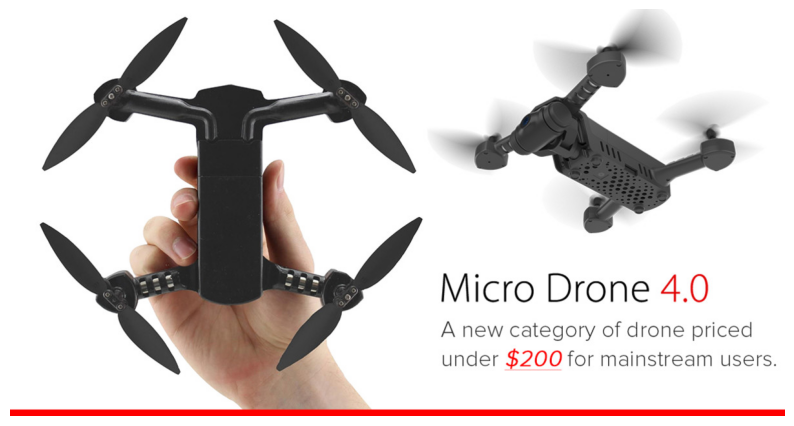

In [9]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 694 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 479.5, 319.5, -0.5)

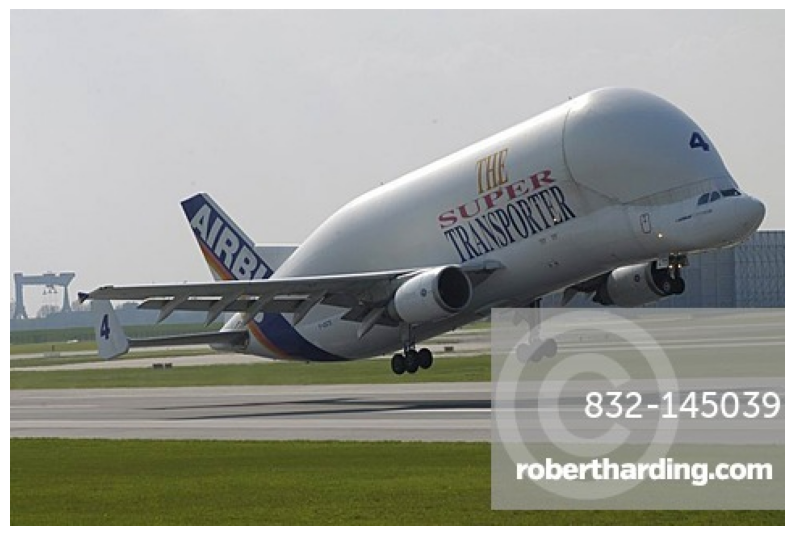

In [10]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 699 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych
Ale tylko treningowych!!


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir, # nowe zdjęcia nie są zapisywane, są tworzone w locie
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,  # lokalizacja zbioru walidacyjnego
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [12]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]

    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

Jeśli mamy katalog my_directory zawierający pliki file1.txt i file2.txt, to wynikowy kod:
```
python

fnames = [os.path.join('my_directory', fname) for fname in os.listdir('my_directory')]
```
zwróci listę:
```
python

['my_directory/file1.txt', 'my_directory/file2.txt']
```
To pozwala łatwo uzyskać pełne ścieżki do wszystkich plików w katalogu.

`img_to_array(img)`:

  Konwertuje obraz w formacie PIL (Python Imaging Library) lub innym zgodnym formacie na tablicę NumPy, która jest popularnym sposobem reprezentacji danych w formie macierzy w Pythonie. Taka tablica może być używana do obliczeń, np. w sieciach neuronowych.

  
Przykład:

Dla obrazu RGB o rozmiarach 256x256 pikseli, wynikowa tablica będzie miała wymiary (256, 256, 3), gdzie "3" odpowiada za trzy kanały koloru (R, G, B).

` x = x.reshape((1, ) + x.shape)`

Ten kod zmienia kształt (wymiary) tablicy x za pomocą metody reshape(), dodając nowy wymiar na początku. Oto co dokładnie robi:

  x.reshape((1, ) + x.shape):
        
        Funkcja reshape() zmienia kształt tablicy x na nowy wymiar.
        (1,) + x.shape:
            Tu dodawany jest nowy wymiar o rozmiarze 1 na początku istniejących wymiarów.
            x.shape to oryginalne wymiary tablicy x. Dzięki + wymiary oryginalne są dodawane do krotki (1,), co daje nowy kształt.

  Dodanie wymiaru:

        Jeśli pierwotnie x miało kształt (np. dla obrazu RGB o wymiarach 256x256): (256, 256, 3), to po przekształceniu będzie miało kształt: (1, 256, 256, 3).

  Dlaczego to robimy?:
  
        Dodanie wymiaru o rozmiarze 1 na początku tablicy jest często używane w sieciach neuronowych, gdzie modele wymagają, aby dane wejściowe miały kształt: (liczba przykładów, wysokość, szerokość, liczba kanałów).
        W tym przypadku, oryginalny obraz miał wymiary (wysokość, szerokość, liczba kanałów). Dodanie wymiaru 1 symuluje "partię" (batch) o wielkości 1, ponieważ algorytmy sieci neuronowych zazwyczaj przetwarzają obrazy w partiach.

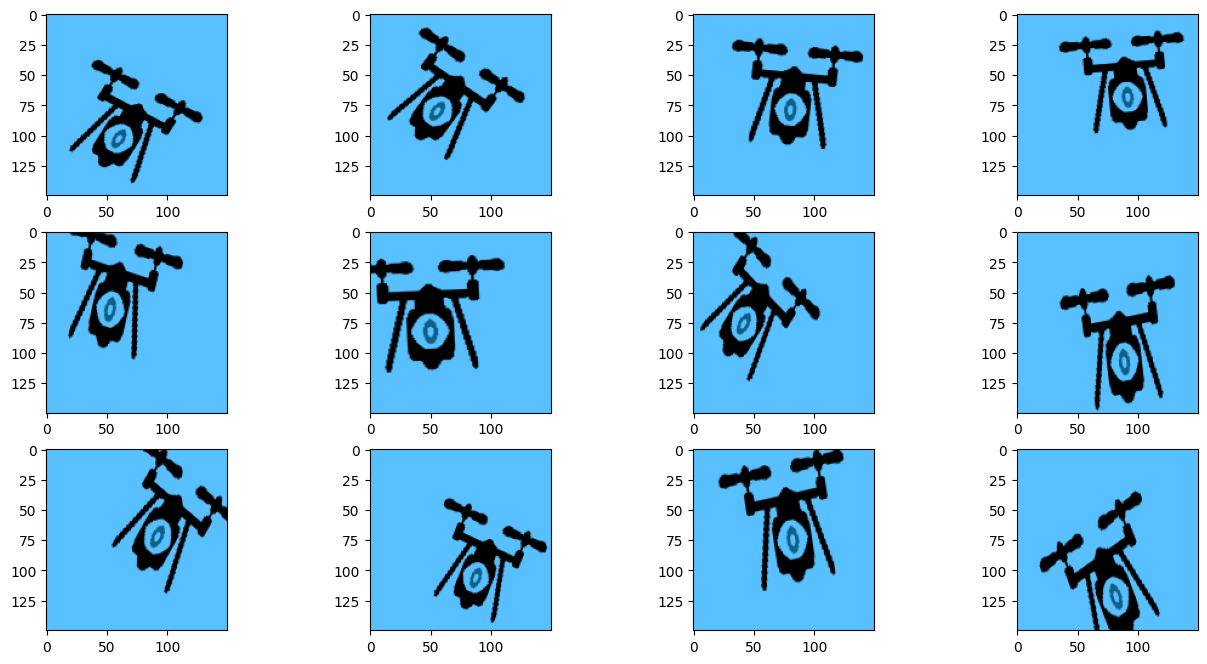

In [13]:
#@title Zbiór treningowy drone:
idx = 467 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_drone_dir, idx)

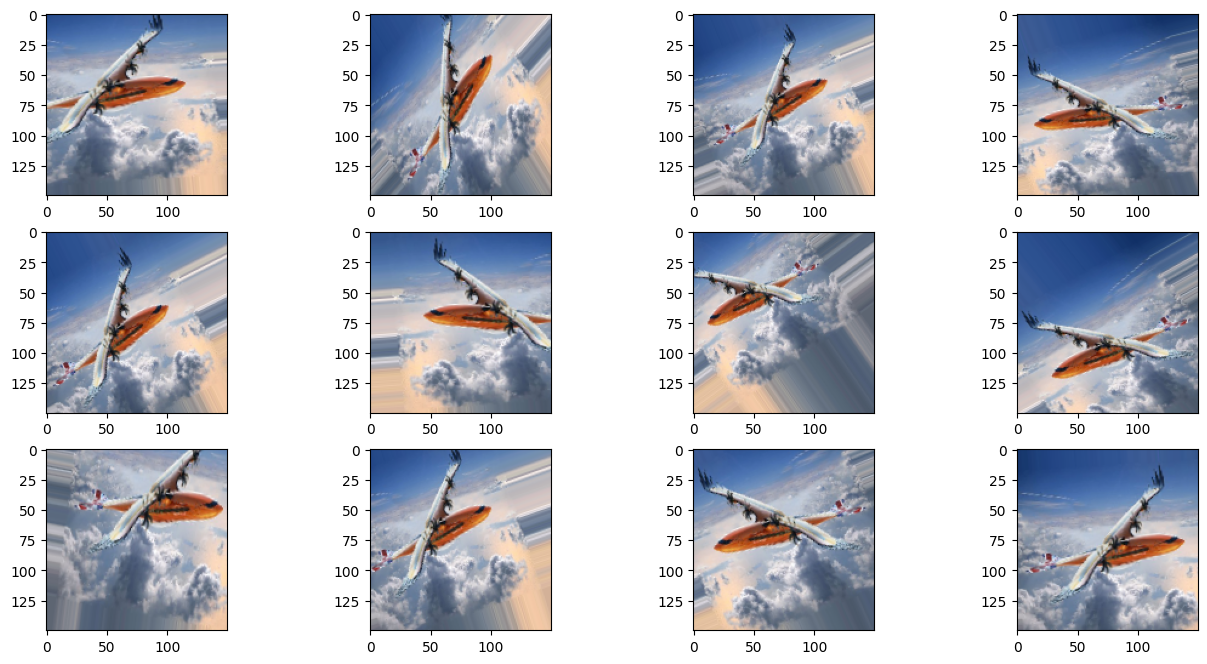

In [14]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

### <a name='a5'></a> Budowa modelu

In [15]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), # Use learning_rate instead of lr
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [17]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [18]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,    # 100
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[tensorboard]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5283 - loss: 0.6968 - val_accuracy: 0.4883 - val_loss: 0.6968
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5319 - loss: 0.6911 - val_accuracy: 0.5117 - val_loss: 0.6879
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4040 - loss: 0.6943 - val_accuracy: 0.4167 - val_loss: 0.6957
Epoch 4/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


28/28 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5061 - loss: 0.6929 - val_accuracy: 0.5273 - val_loss: 0.6870
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5201 - loss: 0.6908 - val_accuracy: 0.5078 - val_loss: 0.6909
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.5452 - loss: 0.6825 - val_accuracy: 0.6667 - val_loss: 0.6950
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5688 - loss: 0.6828 - val_accuracy: 0.4961 - val_loss: 0.6924
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5744 - loss: 0.6861 - val_accuracy: 0.5820 - val_loss: 0.6631
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5346 - loss: 0.6783 - val_accuracy: 0.6667 - val_loss: 0.6505
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5709 - loss: 0.6776 - val_accuracy: 0.5781 - val_loss: 0.6634
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5862 - loss: 0.6769 - val_accuracy: 0.5039 - val_loss: 0.695

In [19]:
%load_ext tensorboard

In [20]:
!tensorboard dev upload --logdir logs

2024-10-19 18:14:19.359872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 18:14:19.383652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 18:14:19.390653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 18:14:20.885111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


In [21]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

### <a name='a6'></a> Transfer learning - model VGG16

In [22]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
# model.summary()

In [24]:
print(f'Liczba warstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')

Liczba warstw trenowanych przed zamrożeniem 26
Liczba warstw trenowanych po zamrożeniu 0


In [25]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), # Changed lr to learning_rate
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [26]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 323s 11s/step - accuracy: 0.5593 - loss: 0.7398 - val_accuracy: 0.7891 - val_loss: 0.4881
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 316s 11s/step - accuracy: 0.7452 - loss: 0.5289 - val_accuracy: 0.7617 - val_loss: 0.4755
Epoch 3/50
 2/28 ━━━━━━━━━━━━━━━━━━━━ 3:12 7s/step - accuracy: 0.7969 - loss: 0.4631

/usr/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.7824 - loss: 0.4900 - val_accuracy: 0.7500 - val_loss: 0.5703
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 344s 11s/step - accuracy: 0.7224 - loss: 0.5132 - val_accuracy: 0.7773 - val_loss: 0.4661
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 318s 11s/step - accuracy: 0.7773 - loss: 0.4700 - val_accuracy: 0.8086 - val_loss: 0.3981
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7360 - loss: 0.5725 - val_accuracy: 0.7500 - val_loss: 0.4299
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 327s 12s/step - accuracy: 0.7842 - loss: 0.4551 - val_accuracy: 0.7969 - val_loss: 0.4079
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 310s 11s/step - accuracy: 0.7459 - loss: 0.4776 - val_accuracy: 0.7969 - val_loss: 0.4286
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.7327 - loss: 0.4533 - val_accuracy: 0.9167 - val_loss: 0.2120
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 325s 12s/step - accuracy: 0.7638 - loss: 0.4849 - val_accuracy: 0.8242 - 

KeyboardInterrupt: 

In [27]:
import plotly.graph_objects as go
plot_hist(history)

### <a name='a7'></a> Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw

In [28]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_layer_3 trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [29]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_layer_3 trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [32]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

# model.summary()

In [ ]:
history = model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=10,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 373s 13s/step - accuracy: 0.5454 - loss: 0.6943 - val_accuracy: 0.7109 - val_loss: 0.5766
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 357s 13s/step - accuracy: 0.6890 - loss: 0.5840 - val_accuracy: 0.7852 - val_loss: 0.4595
Epoch 3/10
 2/28 ━━━━━━━━━━━━━━━━━━━━ 4:36 11s/step - accuracy: 0.6406 - loss: 0.5882

/usr/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.6551 - loss: 0.5930 - val_accuracy: 0.8333 - val_loss: 0.4773
Epoch 4/10
 8/28 ━━━━━━━━━━━━━━━━━━━━ 3:33 11s/step - accuracy: 0.7347 - loss: 0.5330

In [ ]:
plot_hist(history)

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

In [ ]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

In [ ]:
y_true = test_generator.classes
y_true

In [ ]:
y_pred = predictions['class'].values
y_pred

In [ ]:
test_generator.class_indices

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

In [ ]:
print(classification_report(y_true, y_pred))

### <a name='a9'></a> Wyświetlenie błędów predykcji

In [ ]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

In [ ]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

In [ ]:
errors[errors['is_incorrect'] == 1].index

In [ ]:
img_path = os.path.join(test_drone_dir, '00000183.JPG')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
errors[errors['is_incorrect'] == 1].index

In [ ]:
img_path = os.path.join(test_passenger_dir, '00001453.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)